In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import uproot
import sys
import math

dir = "/Users/alexanderantonakis/Desktop/Software/AFrameAnalysis/Macros/"

sys.path.append("../Utils")
sys.path.append("../Configs")

from ChannelMap import ChannelMap

frame = 7
strip_w = 11.2 # cm 
cluster_file = "clusters_frame7.root"
config = "config_frame7.txt"
run_config = "run_config_frame7.txt"

goal = 0.95
outfile = "bias_settings_frame"+str(frame)+"_goal_"+str(int(100*goal))+".root"

cuts = [
    "chi_dof < 1.5",
    "theta < 85",
    "dtCut < 75",
]

fig_dir = "../Figs/Frame"+str(frame)+"/"

# set up the geometry of the frame
map = ChannelMap("../Configs/"+config, "../Configs/"+run_config)
map.initialize_config()
map.initialize_run_config()
map.calculate_params()
print("initialized the geometry and voltages")
print("")

# initialize the horizontal febs --> useful to have
febs = map.mac5
horiz_febs = []
for feb in febs:
    if map.is_horiz(feb):
        horiz_febs.append(feb)
        
print("All Horizontal FEBs in this file:", horiz_febs)


# Open the ROOT file and the TTree
file = uproot.open(cluster_file)  # Replace with your ROOT file
tree = file["cluster_tree"]    

# Convert the TTree to a pandas DataFrame
df = tree.arrays(library="pd")

df[:2]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Welcome to JupyROOT 6.28/04
['72', '75', '199', '198', '197', '200', '202', '203', '76', '71', '']
['113.2', '120.5', '0', '0', '0', '0', '0', '0', '115', '116.8', '']
['4', '-9.1', '-9.25', '-8.1', '-4', '3.85', '8.35', '8.4', '8.35', '']
['29.2', '-16.55', '-15.3', '-8.3', '-4.4', '4.3', '8.6', '15.35', '16.55', '']
['2', '2', '0', '0', '0', '1', '1', '1', '2', '2', '']
['1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '']
['4243', '4244', '4245', '4246', '']
['215', '200', '185', '170', '140

,strips,times,adcA,adcB
0,[4243 5 5 -1 6 6 6],[4243 2573181 2573177 -1 2573163 2573164 2573162],[4243 2985 1620 -1 3667 2483 2307],[4243 1120 1243 -1 2982 1640 4030]
1,[4243 8 8 8 6 6 6],[4243 5248053 5248055 5248101 5248048 5248047 ...,[4243 2996 1880 1485 416 1876 1421],[4243 3735 1426 486 2378 2799 2206]


In [2]:
strip_df = pd.DataFrame(df['strips'].tolist())
columns = ["Run"]
for feb in horiz_febs:
    columns.append("FEB"+str(feb))
strip_df.columns = columns

print("made the strip dataframe")
strip_df[:5]

made the strip dataframe


,Run,FEB199,FEB198,FEB197,FEB200,FEB202,FEB203
0,4243,5,5,-1,6,6,6
1,4243,8,8,8,6,6,6
2,4243,-1,-1,0,0,0,-1
3,4243,6,5,5,2,2,2
4,4243,10,10,10,11,11,11


In [3]:
time_df = pd.DataFrame(df['times'].tolist())

time_df.columns = columns

print("made the time dataframe")
time_df[:5]

made the time dataframe


,Run,FEB199,FEB198,FEB197,FEB200,FEB202,FEB203
0,4243,2573181,2573177,-1,2573163,2573164,2573162
1,4243,5248053,5248055,5248101,5248048,5248047,5248046
2,4243,-1,-1,16492375,16492379,16492380,-1
3,4243,23358498,23358499,23358500,23358512,23358510,23358506
4,4243,36002599,36002595,36002593,36002598,36002593,36002598


In [4]:
adcA_df = pd.DataFrame(df['adcA'].tolist())

adcA_df.columns = columns

print("made the adcA dataframe")
adcA_df[:5]

made the adcA dataframe


,Run,FEB199,FEB198,FEB197,FEB200,FEB202,FEB203
0,4243,2985,1620,-1,3667,2483,2307
1,4243,2996,1880,1485,416,1876,1421
2,4243,-1,-1,2258,4089,621,-1
3,4243,4089,2522,4089,1036,1153,3632
4,4243,1192,720,772,1144,822,853


In [5]:
adcB_df = pd.DataFrame(df['adcB'].tolist())

adcB_df.columns = columns

print("made the adcB dataframe")
adcB_df[:5]

made the adcB dataframe


,Run,FEB199,FEB198,FEB197,FEB200,FEB202,FEB203
0,4243,1120,1243,-1,2982,1640,4030
1,4243,3735,1426,486,2378,2799,2206
2,4243,-1,-1,2065,1755,1888,-1
3,4243,4089,3852,1804,3337,2734,2399
4,4243,1896,630,1819,3208,1839,4089


In [6]:
runs = list(set(list(strip_df['Run'].values)))
print("runs", runs)

runs [4243, 4244, 4245, 4246]


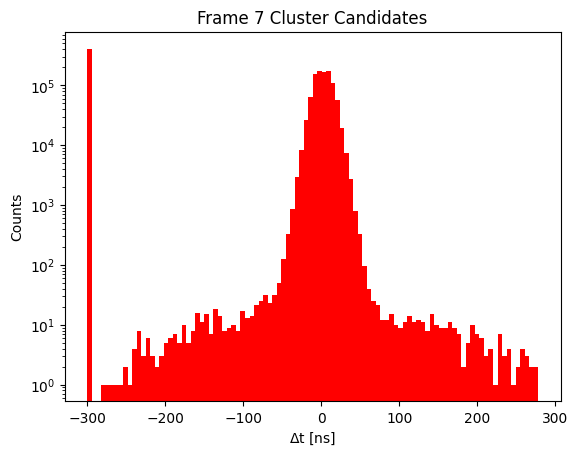

In [7]:
def deltaT(row):
    diff = -300
    if row["FEB"+str(horiz_febs[0])] > -1 and row["FEB"+str(horiz_febs[-1])] > -1:
        diff = row["FEB"+str(horiz_febs[0])] - row["FEB"+str(horiz_febs[-1])]     
    return diff

time_df["deltT"] = time_df.apply(deltaT, axis=1)

plt.hist(time_df["deltT"].values, bins=100, color="r")
plt.xlabel(r"$\Delta$t [ns]")
plt.ylabel("Counts")
plt.title("Frame "+str(frame)+" Cluster Candidates")
plt.yscale("log")
plt.show()


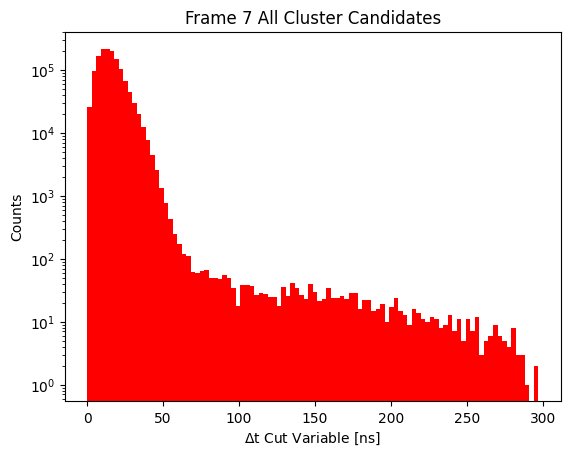

In [8]:
def deltaTCut(row):
    t_vals = []
    for feb in horiz_febs:
        t = row["FEB"+str(feb)]
        if t != -1:
            t_vals.append(t)
    dt = max(t_vals) - min(t_vals)
    return dt
    
time_df['dtCut'] = time_df.apply(deltaTCut, axis=1)

plt.hist(time_df["dtCut"].values, bins=100, color="r")
plt.xlabel(r"$\Delta$t Cut Variable [ns]")
plt.ylabel("Counts")
plt.title("Frame "+str(frame)+" All Cluster Candidates")
plt.yscale("log")
plt.show()

In [9]:
feb_h_indices = [map.mac5.index(horiz_febs[num]) for num in range(len(horiz_febs))]
angles_h = [map.angle[feb_h_indices[num]] for num in range(len(feb_h_indices))] 

# apply uniform errors
sigma = strip_w/np.sqrt(12.0)

# errors for each horizontal module
all_err_z = [sigma*np.cos(angles_h[num]) for num in range(len(angles_h))]
all_err_y = [sigma*np.sin(angles_h[num]) for num in range(len(angles_h))]

print("calculated uniform hit errors")

calculated uniform hit errors


In [10]:
def calculate_z(row):
    z_vals = []
    for feb in horiz_febs:
        strip = row["FEB"+str(feb)]
        if strip == -1:
            # give an absurd value
            z_vals.append(-999.)
        else:
            idx = map.mac5.index(feb)
            zpos = map.zpos[idx]
            angle = map.angle[idx]
            direction = map.channel_ascending[idx]
            hypotenuse1 = strip*strip_w + (strip_w/2)
            hypotenuse2 = 16*strip_w - strip*strip_w
            if zpos < 0:
                if direction:
                    z_vals.append(np.cos(angle)*hypotenuse1 + zpos)
                else:
                    z_vals.append(np.cos(angle)*hypotenuse2 + zpos)         
            else:
                if direction:
                    z_vals.append(zpos - np.cos(angle)*hypotenuse1)
                else:
                    z_vals.append(zpos - np.cos(angle)*hypotenuse2)
    return z_vals

strip_df['z'] = strip_df.apply(calculate_z, axis=1)
strip_df[:4]

,Run,FEB199,FEB198,FEB197,FEB200,FEB202,FEB203,z
0,4243,5,5,-1,6,6,6,"[-14.139111111111092, -10.102222222222215, -99..."
1,4243,8,8,8,6,6,6,"[-16.528444444444432, -12.528888888888883, -8...."
2,4243,-1,-1,0,0,0,-1,"[-999.0, -999.0, -2.0559999999999796, 2.055999..."
3,4243,6,5,5,2,2,2,"[-14.935555555555537, -10.102222222222215, -5...."


In [11]:
z_df = pd.DataFrame(strip_df['z'].tolist())

z_df.columns = columns[1:]
z_df['Run'] = strip_df['Run']
z_df[:4]

,FEB199,FEB198,FEB197,FEB200,FEB202,FEB203,Run
0,-14.139111,-10.102222,-999.000,6.760,10.780,15.204444,4243
1,-16.528444,-12.528889,-8.328,6.760,10.780,15.204444,4243
2,-999.000000,-999.000000,-2.056,2.056,5.908,-999.000000,4243
3,-14.935556,-10.102222,-5.976,3.624,7.532,12.006222,4243


In [12]:
def calculate_y(row):
    y_vals = []
    for feb in horiz_febs:
        strip = row["FEB"+str(feb)]
        if strip != -999.0:
            idx = map.mac5.index(feb)
            angle = map.angle[idx]
            direction = map.channel_ascending[idx]
            hypotenuse1 = strip*strip_w + (strip_w/2)
            hypotenuse2 = 16*strip_w - strip*strip_w
            if direction:
                y_vals.append(hypotenuse1*np.sin(angle))
            else:
                y_vals.append(hypotenuse2*np.sin(angle))
        else:
            y_vals.append(-999.0)
            
    return y_vals
    
strip_df['y'] = strip_df.apply(calculate_y, axis=1)
strip_df[:4]        

,Run,FEB199,FEB198,FEB197,FEB200,FEB202,FEB203,z,y
0,4243,5,5,-1,6,6,6,"[-14.139111111111092, -10.102222222222215, -99...","[122.88810693422101, 122.87827127127595, 189.9..."
1,4243,8,8,8,6,6,6,"[-16.528444444444432, -12.528888888888883, -8....","[89.37316867943348, 89.36601547001888, 89.3802..."
2,4243,-1,-1,0,0,0,-1,"[-999.0, -999.0, -2.0559999999999796, 2.055999...","[189.91798344379612, 189.9027828737901, 178.76..."
3,4243,6,5,5,2,2,2,"[-14.935555555555537, -10.102222222222215, -5....","[111.71646084929185, 122.87827127127595, 122.8..."


In [13]:
y_df = pd.DataFrame(strip_df['y'].tolist())

y_df.columns = columns[1:]
y_df['Run'] = strip_df['Run']
y_df[:4]

,FEB199,FEB198,FEB197,FEB200,FEB202,FEB203,Run
0,122.888107,122.878271,189.932947,111.725263,111.705262,111.714239,4243
1,89.373169,89.366015,89.380210,111.725263,111.705262,111.714239,4243
2,189.917983,189.902783,178.760421,178.760421,178.728419,189.914206,4243
3,111.716461,122.878271,122.897789,156.415368,156.387367,156.399934,4243


In [14]:
import ROOT

def line_fit(row1, row2):
    N = 0
    g0 = ROOT.TGraphErrors()
    for feb in horiz_febs:
        z = row1["FEB"+str(feb)]
        y = row2["FEB"+str(feb)]
        if z > -990.0:
            idx = horiz_febs.index(feb)
            g0.SetPoint(N, z, y)
            g0.SetPointError(N, all_err_z[idx], all_err_y[idx])
            N += 1

    # Define a linear function (y = mx + b)
    linear_func = ROOT.TF1("linear_func", "[0]*x + [1]")
    dx = g0.GetPointX(0) - g0.GetPointX(N-1)
    dy = g0.GetPointY(0) - g0.GetPointY(N-1)
    
    m_start = 1.0
    if dx != 0.0:
        m_start = dy/dx

    b0 = g0.GetPointY(N-1) - m_start*g0.GetPointX(N-1)
    b1 = g0.GetPointY(0) - m_start*g0.GetPointX(0)    
    b_start = (b0 + b1)/2.0
    
    # Set some initial parameters for the fit
    linear_func.SetParameter(0, m_start)
    linear_func.SetParameter(1, b_start)

    # Fit the graph with the linear function
    #g0.Fit("linear_func", "", "BRQE")
    g0.Fit("linear_func", "Q", "")
    # Get the fit results
    fit_results0 = g0.GetFunction("linear_func")

    m0, b0 = fit_results0.GetParameter(0), fit_results0.GetParameter(1)    
    m0_err, b0_err = fit_results0.GetParError(0), fit_results0.GetParError(1)
    chis = g0.Chisquare(g0.GetFunction("linear_func"))
        
    return [m0, b0, m0_err, b0_err, chis, N]



# Use zip to combine rows from both DataFrames and apply the function
result = z_df.apply(lambda row1: line_fit(row1, y_df.loc[row1.name]), axis=1)

fit_df = pd.DataFrame(result.tolist(), columns=['m', 'b', 'm_err', 'b_err', 'chis', 'N'])
fit_df[:4]

,m,b,m_err,b_err,chis,N
0,-0.453734,116.953939,0.123685,1.458227,0.920211,5
1,0.881484,101.225728,0.108394,1.321848,5.593120,6
2,-0.003973,178.757578,0.572571,2.176926,0.000017,3
3,1.880410,140.243260,0.137064,1.340455,16.331715,6


In [15]:
import math
# Let's add the zenith angle
def get_theta(row):
    m = row['m']
    theta = ((math.pi/2) - np.arctan(abs(m)))*(180/math.pi)
    return theta

fit_df['theta'] = fit_df.apply(get_theta, axis=1)
fit_df[:4]

,m,b,m_err,b_err,chis,N,theta
0,-0.453734,116.953939,0.123685,1.458227,0.920211,5,65.594573
1,0.881484,101.225728,0.108394,1.321848,5.593120,6,48.604330
2,-0.003973,178.757578,0.572571,2.176926,0.000017,3,89.772344
3,1.880410,140.243260,0.137064,1.340455,16.331715,6,28.003994


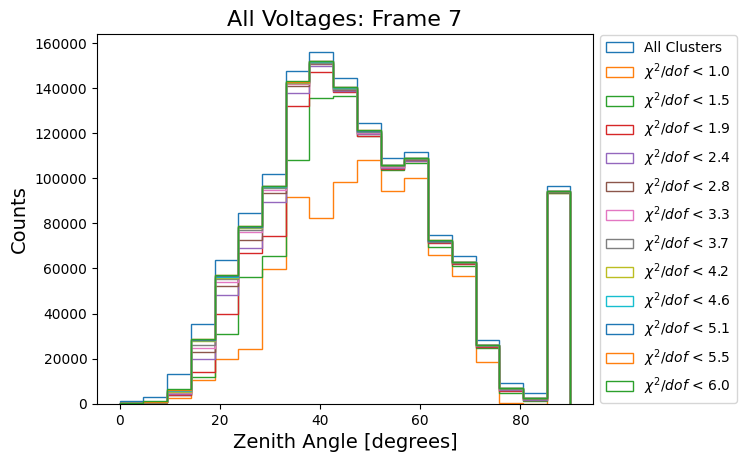

In [16]:
chis_per_N_vals = np.linspace(1, 6, 12)
theta_bins = np.linspace(0, 90, 20)

plt.hist(fit_df['theta'].values, bins=theta_bins, histtype="step", label = "All Clusters")
for num in chis_per_N_vals:
    plt.hist(fit_df.query("chis/N < @num")['theta'].values, 
             bins=theta_bins, histtype="step", label=r"$\chi^{2}/dof$ < "+str(round(num, 1)))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Zenith Angle [degrees]", fontsize=14)
plt.ylabel("Counts", fontsize=14)
plt.title("All Voltages: Frame "+str(frame), fontsize=16)
plt.show()

In [17]:
fit_df["chi_dof"] = fit_df["chis"]/fit_df["N"]
fit_df[:4]

,m,b,m_err,b_err,chis,N,theta,chi_dof
0,-0.453734,116.953939,0.123685,1.458227,0.920211,5,65.594573,0.184042
1,0.881484,101.225728,0.108394,1.321848,5.593120,6,48.604330,0.932187
2,-0.003973,178.757578,0.572571,2.176926,0.000017,3,89.772344,0.000006
3,1.880410,140.243260,0.137064,1.340455,16.331715,6,28.003994,2.721952


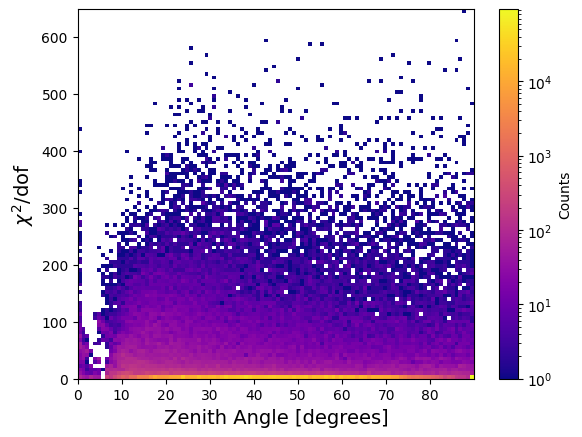

In [18]:
from matplotlib.colors import LogNorm

plt.hist2d(fit_df['theta'].values, 
           fit_df['chis'].values / fit_df['N'].values, bins=100, cmap="plasma", norm=LogNorm())

plt.colorbar(label='Counts')
plt.xlabel("Zenith Angle [degrees]", fontsize=14)
plt.ylabel(r"$\chi^2$/dof", fontsize=14)
plt.show()

# Efficiency Extraction

In [19]:

# define eff histograms
numerators_cross = []
denominators_cross = []
for num in range(len(horiz_febs)):
    feb_index = map.mac5.index(horiz_febs[num]) 
    z = map.zpos[feb_index]
    minz, maxz = 0., 0.
    if z > 0:
        maxz = z
        minz = maxz - map.module_width_h*np.cos(map.angle[feb_index])
    else:
        minz = z
        maxz = minz + map.module_width_h*np.cos(map.angle[feb_index])
    
    numerators_cross.append(ROOT.TH1D("h_num_cross_feb"+str(horiz_febs[num]), "", 16, minz, maxz))
    denominators_cross.append(ROOT.TH1D("h_den_cross_feb"+str(horiz_febs[num]), "", 16, minz, maxz))
                        
print("Made the histograms for efficiency")
print("RESET them for each run")

Made the histograms for efficiency
RESET them for each run


In [20]:
def fill_num_cross(row):
    for num in range(len(horiz_febs)):
        if row["FEB"+str(horiz_febs[num])] > -990:
            numerators_cross[num].Fill(row["FEB"+str(horiz_febs[num])])
            denominators_cross[num].Fill(row["FEB"+str(horiz_febs[num])])
    
print("Made function for defining the numerator of the efficiency")
print("Must use the z_df")

Made function for defining the numerator of the efficiency
Must use the z_df


In [21]:
def was_hit(m, b, feb):
    index = map.mac5.index(feb)
    zint = (map.b[index] - b) /(m - map.m[index])
    yint = m*zint + b
    if 0 <= yint <= map.ymax[index]:
        return 1
    else:
        return 0


def get_hit(m, b, feb):
    index = map.mac5.index(feb)
    zint = (map.b[index] - b) /(m - map.m[index])
    #yint = m*zint + b
    return zint

# row1 is fit_df, row2 is z_df --> Merge the fit and z dataframes
def fill_bad(row):
    m = row['m']
    b = row['b']
    for num in range(len(horiz_febs)):
        if row["FEB"+str(horiz_febs[num])] < -990:
            # wasn't hit -- > check that it's ok 
            flag = was_hit(m, b, horiz_febs[num])
            if flag:
                z_hit = get_hit(m, b, horiz_febs[num])
                denominators_cross[num].Fill(z_hit)

print("Made functions for getting bad hits ;(")

Made functions for getting bad hits ;(


In [22]:
def convert_hist(h):

    # Extract bin edges and bin contents from the ROOT histogram
    nbins = h.GetNbinsX()
    bin_edges = np.zeros(nbins + 1)
    bin_contents = np.zeros(nbins)
    
    for i in range(nbins):
        bin_edges[i] = h.GetBinLowEdge(i + 1)
        bin_contents[i] = h.GetBinContent(i + 1)

    bin_edges[-1] = h.GetBinLowEdge(nbins) + h.GetBinWidth(nbins)  # Last bin upper edge
    return bin_edges, bin_contents
    
print("made function to get python binning from a ROOT TH1D")

made function to get python binning from a ROOT TH1D


The current selection:
chi_dof < 1.5 and theta < 85 and dtCut < 75

Starting Voltage Loop


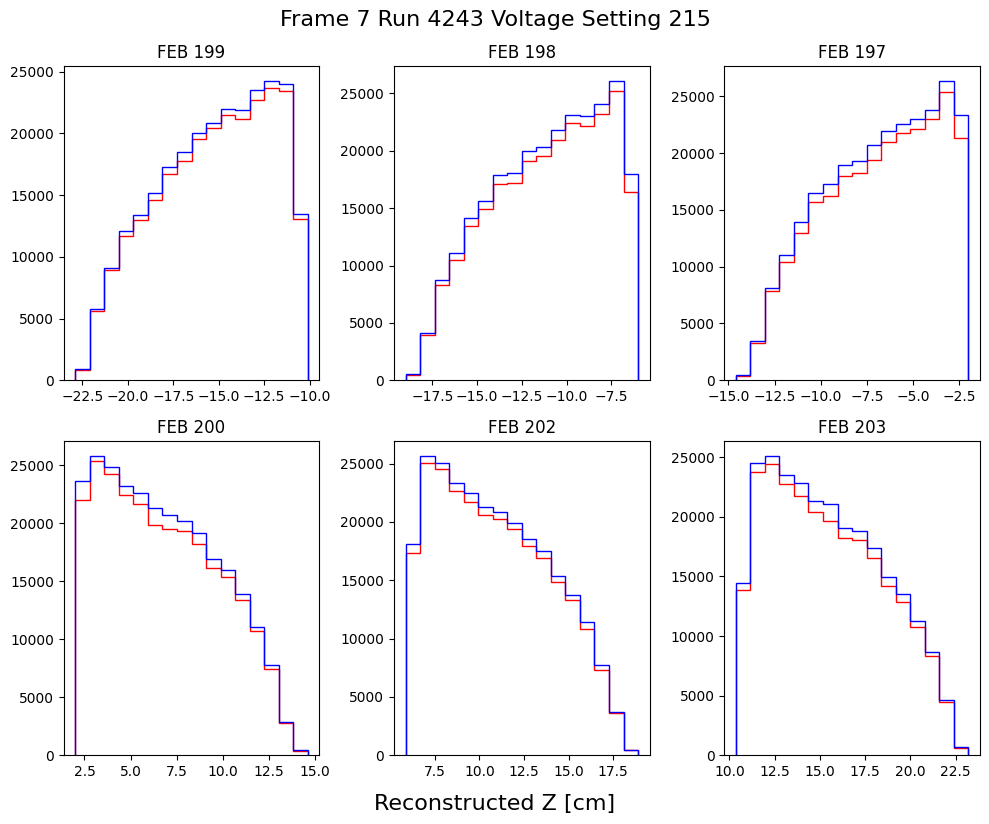

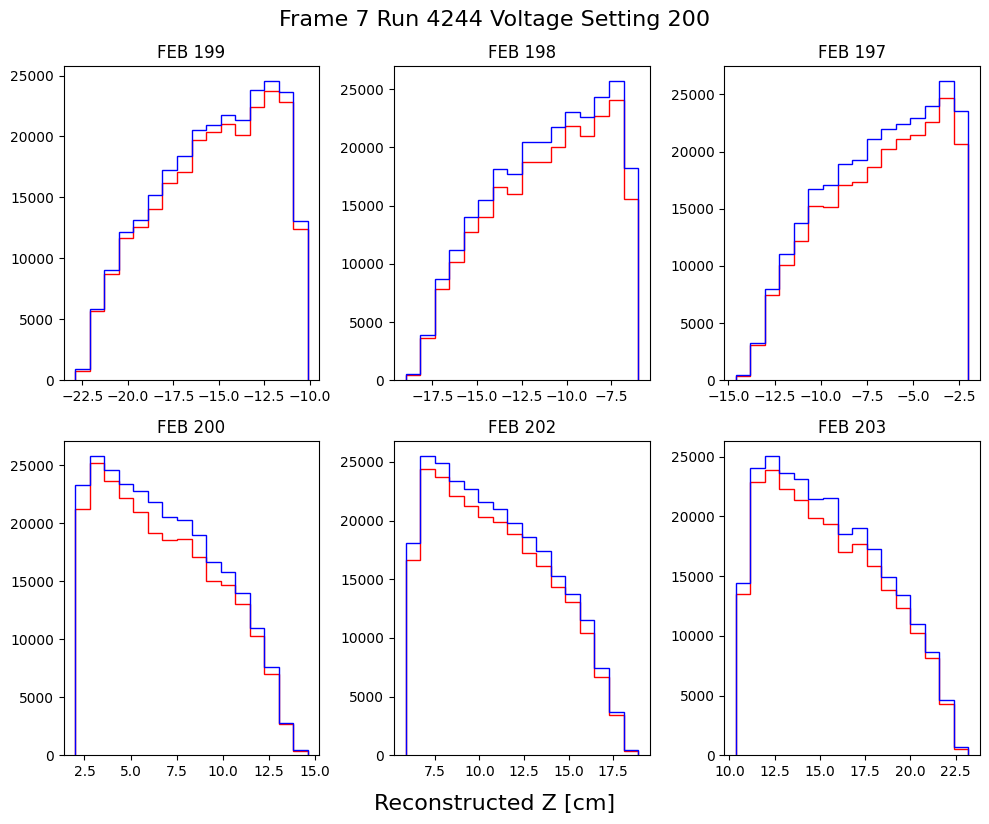

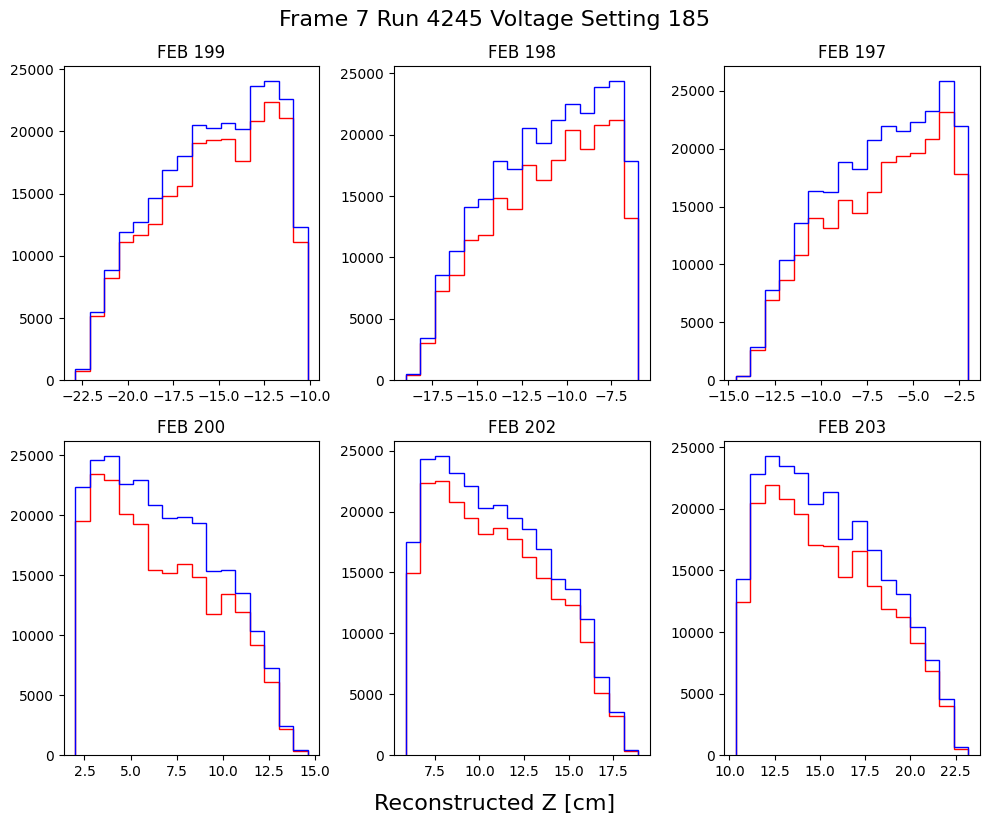

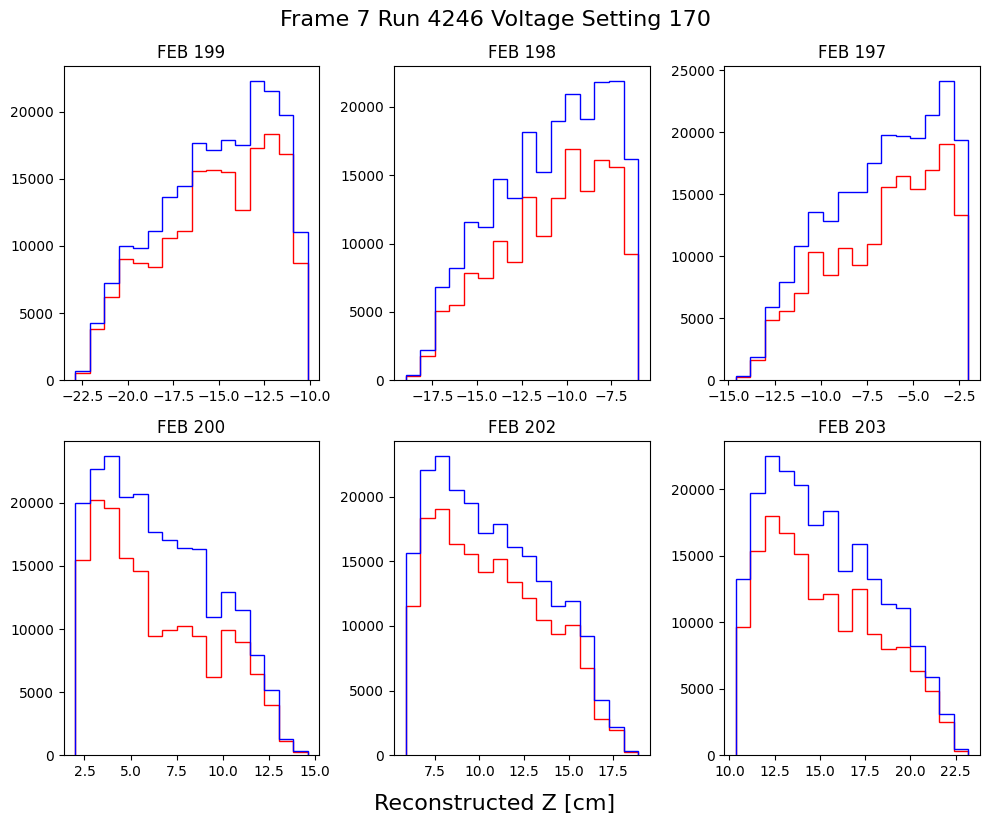

In [23]:
# Efficiency Loop over the different runs/voltages

# Make the efficiency dataframe
eff_df = pd.concat([fit_df, z_df], axis=1)
eff_df['dtCut'] = time_df['dtCut']


# reset histograms
for hist in numerators_cross:
    hist.Reset("ICEM")
    
for hist in denominators_cross:
    hist.Reset("ICEM")

selection = ""
"""
cuts = [
    "chi_dof < 1.5",
    "theta < 85",
    "dtCut < 75",
]
"""
and_op = " and "
for num in range(len(cuts)):
    selection += cuts[num]
    if num != len(cuts)-1:
        selection += and_op

print("The current selection:")
print(selection)
print("")

all_eff_objects = []

rate_directions = []
def get_rate_dir(h):
    nonzero_contents = []
    for num in range(1, h.GetNbinsX()+1):
        if h.GetBinContent(num) > 5:
            nonzero_contents.append(h.GetBinContent(num))
    diff = nonzero_contents[0] - nonzero_contents[-1]
    if h.GetBinCenter(1) < 0:
        # We have FEB on left side
        if diff > 0:
            # strange --> need to flip direction
            return 1
        else:
            return 0
    else:
        # We have FEB on right side 
        if diff < 0:
            # strange --> need to flip direction
            return 1
        else:
            return 0


all_runs = list(set(list(eff_df["Run"].values)))

print("Starting Voltage Loop")
run_count = 0
for run in all_runs:
    run_df = eff_df.query("Run == "+str(run))
    run_df.query(selection).apply(fill_num_cross, axis=1)
    run_df.query(selection).apply(fill_bad, axis=1)
    voltage = map.voltages[map.runs.index(run)]
    eff_objects = []
    for num in range(len(horiz_febs)):
        eff_objects.append(ROOT.TEfficiency(numerators_cross[num], denominators_cross[num]))
        if run_count == 0:
            rate_directions.append(get_rate_dir(denominators_cross[num]))
            
    all_eff_objects.append(eff_objects)
    run_count += 1
    ####################### Rate Plot #######################
    fig, axs = plt.subplots(2, 3, figsize=(10, 8))

    #for num in range(len(horiz_febs)):
    #    bin_edges_num, bin_contents_num = convert_hist(numerators_cross[num])   
    #    bin_edges_den, bin_contents_den = convert_hist(denominators_cross[num])
    count = 0
    for i in range(2):
        for j in range(3):
            
            bin_edges_num, bin_contents_num = convert_hist(numerators_cross[count])   
            bin_edges_den, bin_contents_den = convert_hist(denominators_cross[count])
            # Plot on the first subplot
            axs[i, j].hist(bin_edges_num[:-1], bins=bin_edges_num, weights=bin_contents_num, 
                           histtype='step', color='red')
            axs[i, j].hist(bin_edges_den[:-1], bins=bin_edges_den, weights=bin_contents_den, 
                           histtype='step', color='blue')
            
            axs[i, j].set_title("FEB " + str(horiz_febs[count]))
            
            count += 1
            
    fig.suptitle("Frame "+str(frame)+ " Run " + str(run) + " Voltage Setting "+ str(voltage), fontsize=16)
    #fig.set_title("Run " + str(run))
    # Adjust layout to prevent overlap
    fig.text(0.5, -0.02, 'Reconstructed Z [cm]', ha='center', fontsize=16)
    plt.tight_layout()
    #fig.text(0.5, 0.04, 'Reconstructed Z [cm]', ha='center')
    # Show the plot
    plt.show()
    print("\n")
    
    # reset histograms
    for hist in numerators_cross:
        hist.Reset("ICEM")
    
    for hist in denominators_cross:
        hist.Reset("ICEM")

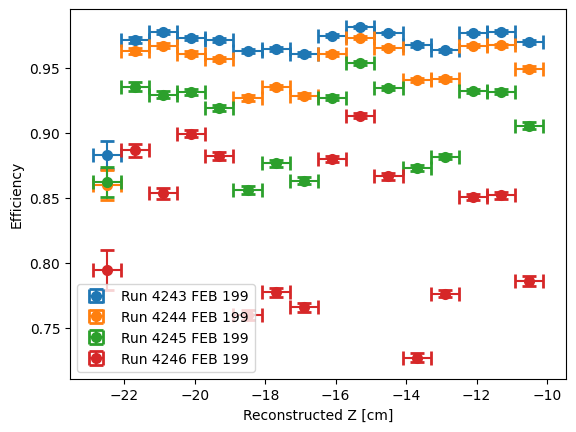

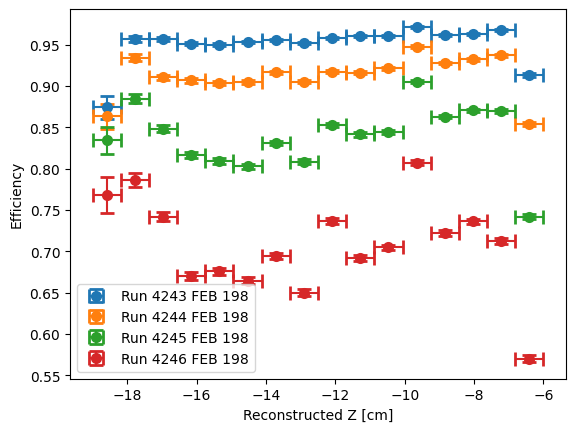

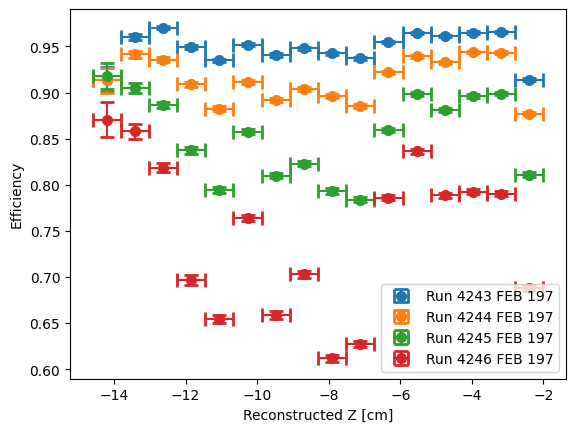

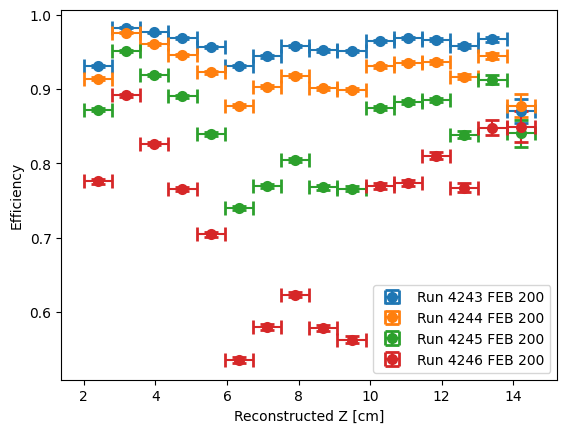

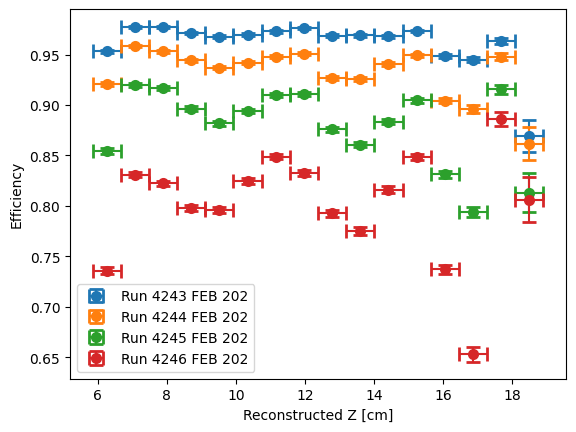

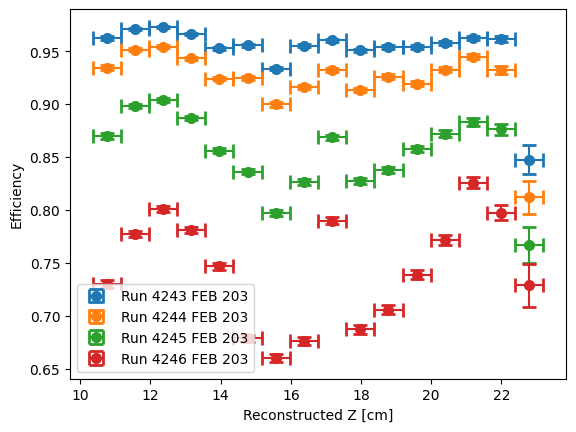

In [24]:
def convert_eff(h):
    nbins = h.GetPassedHistogram().GetNbinsX()
    bin_edges = np.zeros(nbins + 1)
    bin_contents = np.zeros(nbins)
    bin_errors = np.zeros(nbins)
    for i in range(nbins):
        bin_edges[i] = h.GetPassedHistogram().GetBinLowEdge(i + 1)
        bin_contents[i] = h.GetEfficiency(i + 1)
        bin_errors[i] = h.GetEfficiencyErrorUp(i + 1)
        
    bin_edges[-1] = h.GetPassedHistogram().GetBinLowEdge(nbins) + h.GetPassedHistogram().GetBinWidth(nbins)  
    return bin_edges, bin_contents, bin_errors

def convert_eff_hist(h):
    nbins = h.GetNbinsX()
    bin_edges = np.zeros(nbins + 1)
    bin_contents = np.zeros(nbins)
    bin_errors = np.zeros(nbins)
    for i in range(nbins):
        bin_edges[i] = h.GetBinLowEdge(i + 1)
        bin_contents[i] = h.GetBinContent(i + 1)
        bin_errors[i] = h.GetBinError(i + 1)
        
    bin_edges[-1] = h.GetBinLowEdge(nbins) + h.GetBinWidth(nbins)  
    return bin_edges, bin_contents, bin_errors    

def plot_eff(h, l):
    bin_edges, bin_contents, bin_errors = convert_eff(h)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_width = h.GetPassedHistogram().GetBinWidth(1)
    x_errors = np.full(len(bin_contents), bin_width/2)
    plt.errorbar(bin_centers, bin_contents, xerr=x_errors, yerr=bin_errors, 
                 #fmt='o', ecolor='red', capsize=5, capthick=2, markeredgewidth=2, label=l)
                 fmt='o', capsize=5, capthick=2, markeredgewidth=2, label=l)


def plot_eff_hist(h, l):
    bin_edges, bin_contents, bin_errors = convert_eff_hist(h)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_width = h.GetBinWidth(1)
    x_errors = np.full(len(bin_contents), bin_width/2)
    plt.errorbar(bin_centers, bin_contents, xerr=x_errors, yerr=bin_errors, 
                 #fmt='o', ecolor='red', capsize=5, capthick=2, markeredgewidth=2, label=l)
                 fmt='o', capsize=5, capthick=2, markeredgewidth=2, label=l)

    
# i == run , j == feb

for f in range(len(horiz_febs)):
    for num in range(len(all_runs)):    
        plot_eff(all_eff_objects[num][f], "Run "+str(all_runs[num]) + " FEB "+str(horiz_febs[f]))
        
    #plt.title("FEB " + str(f))
    plt.xlabel("Reconstructed Z [cm]")
    plt.ylabel("Efficiency")
    plt.legend()
    plt.show()

In [25]:
# Function to help map positions to channel numbers
def channel_dir(map, feb):
    index = map.mac5.index(feb)
    v = map.channel_ascending[index]
    z0 = map.zpos[index]
    if (v == 1 and z0 < 0 ) or (v == 0 and z0 > 0):
        return 1
    elif (v == 1 and z0 > 0) or (v == 0 and z0 < 0):
        return 0
    else:
        print("Wrong !")
        return -1

channel_directions = []
for feb in horiz_febs:
    channel_directions.append(channel_dir(map, feb))

#channel0 = [num for num in range(16)]
#channel1 = channel0[::-1]

all_strip_eff_objects = []
for num in range(len(all_runs)):
    strip_eff_objects = [ROOT.TH1D("strip_eff_feb"+str(horiz_febs[num]), "", 16, 0, 16) for num in range(len(horiz_febs))]
    for f in range(len(horiz_febs)):
        for s in range(16):
            e = all_eff_objects[num][f].GetEfficiency(s+1)
            err_u = all_eff_objects[num][f].GetEfficiencyErrorUp(s+1)
            err_l = all_eff_objects[num][f].GetEfficiencyErrorLow(s+1)
            if channel_directions[f]:
                strip_eff_objects[f].SetBinContent(s+1, e)
                strip_eff_objects[f].SetBinError(s+1, err_u)
            else:
                strip_eff_objects[f].SetBinContent(16 - s, e)
                strip_eff_objects[f].SetBinError(16 - s, err_u)    
                
    all_strip_eff_objects.append(strip_eff_objects)
            
print("Made Efficiency as function of strip number")

Made Efficiency as function of strip number


Warning in <TROOT::Append>: Replacing existing TH1: strip_eff_feb199 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: strip_eff_feb198 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: strip_eff_feb197 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: strip_eff_feb200 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: strip_eff_feb202 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: strip_eff_feb203 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: strip_eff_feb199 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: strip_eff_feb198 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: strip_eff_feb197 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: strip_eff_feb200 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: strip_ef

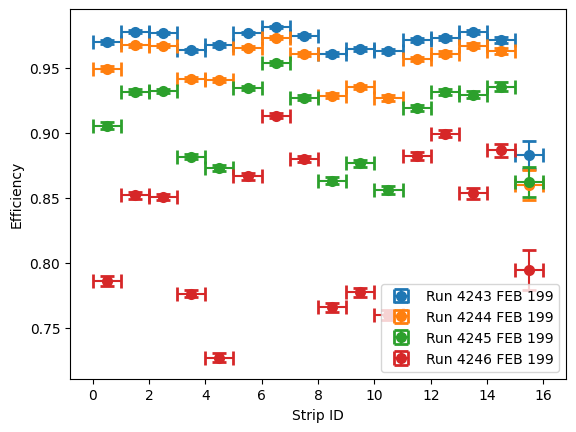

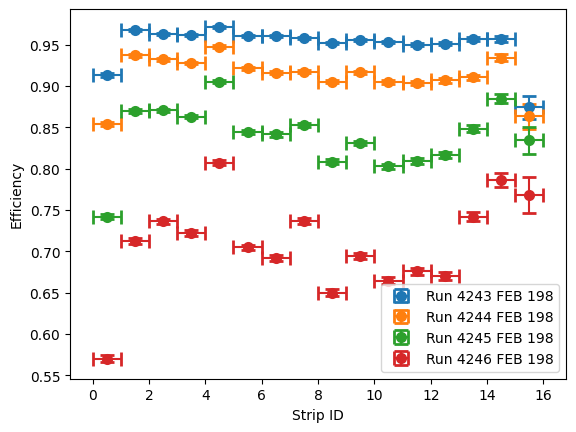

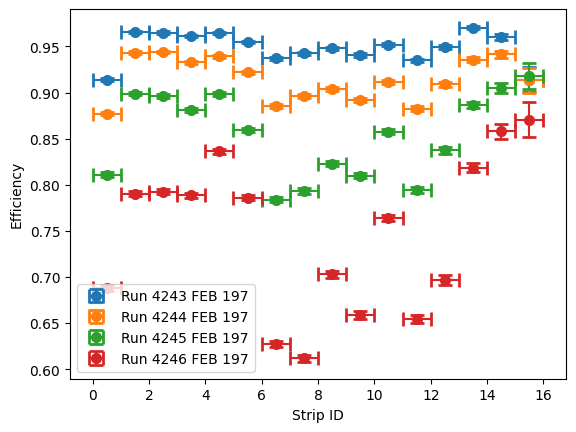

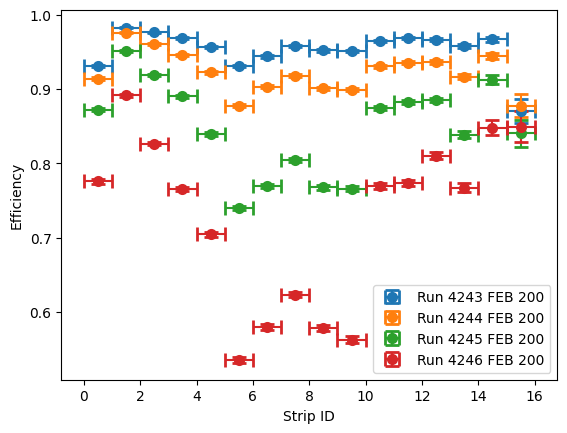

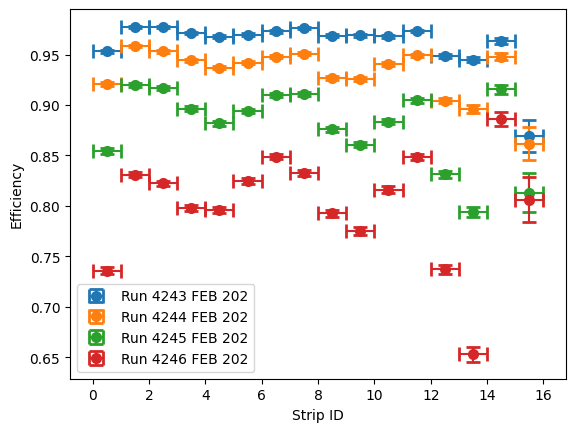

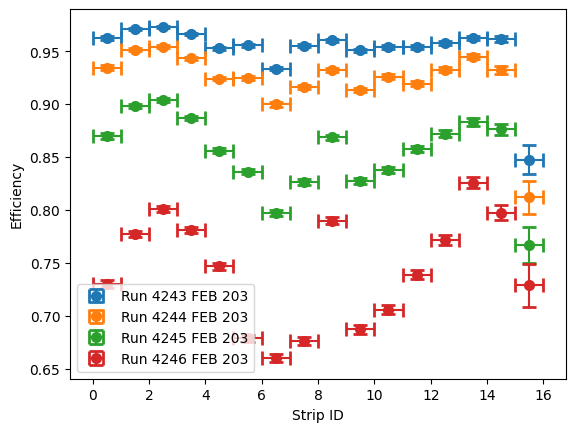

In [26]:
for f in range(len(horiz_febs)):
    for num in range(len(all_runs)):    
        plot_eff_hist(all_strip_eff_objects[num][f], "Run "+str(all_runs[num]) + " FEB "+str(horiz_febs[f]))
        
    #plt.title("FEB " + str(f))
    plt.xlabel("Strip ID")
    plt.ylabel("Efficiency")
    plt.legend()
    plt.show()

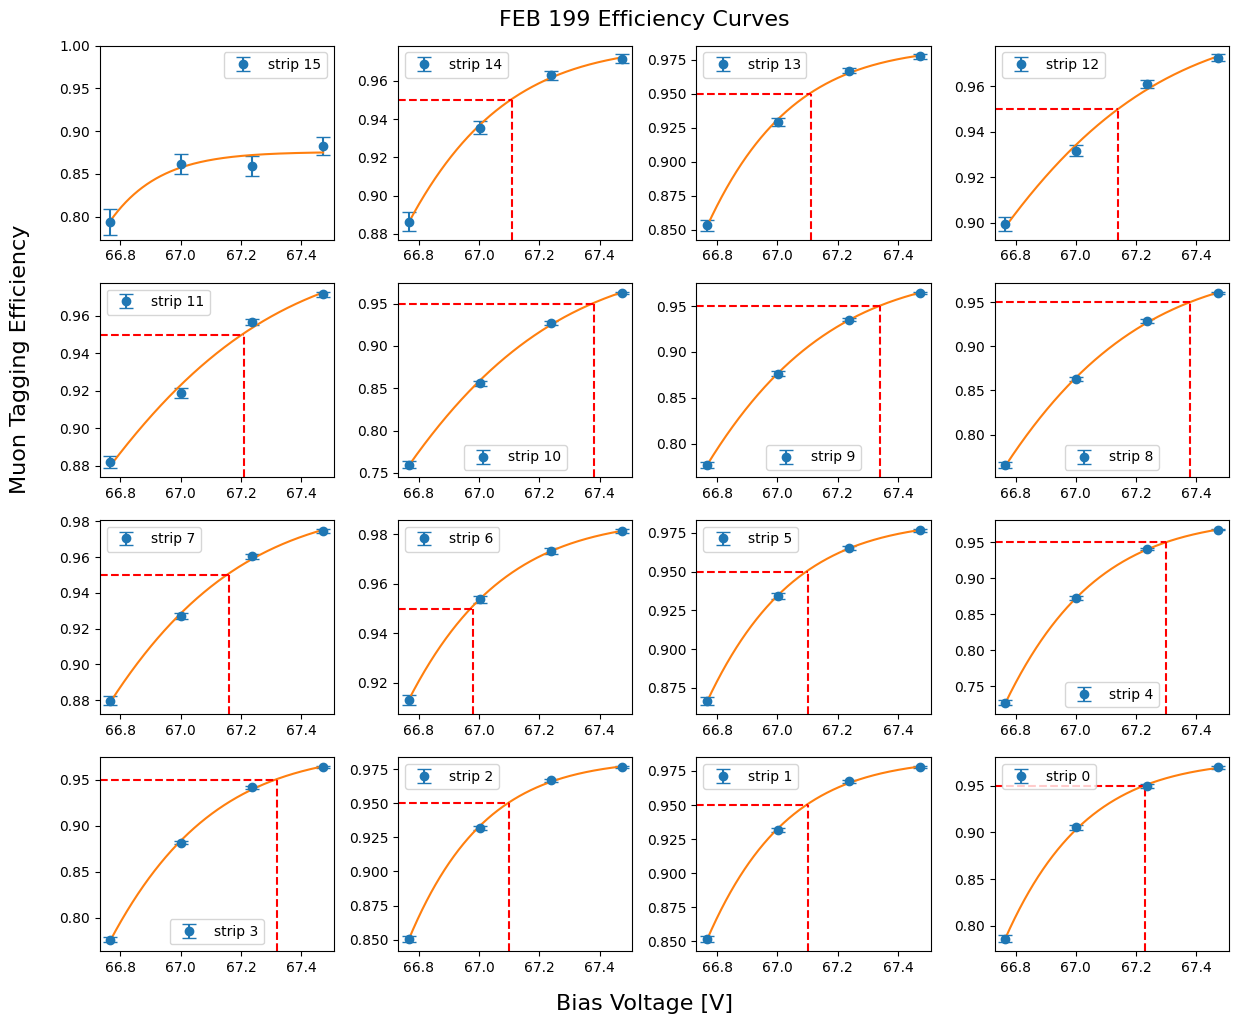

<Figure size 640x480 with 0 Axes>

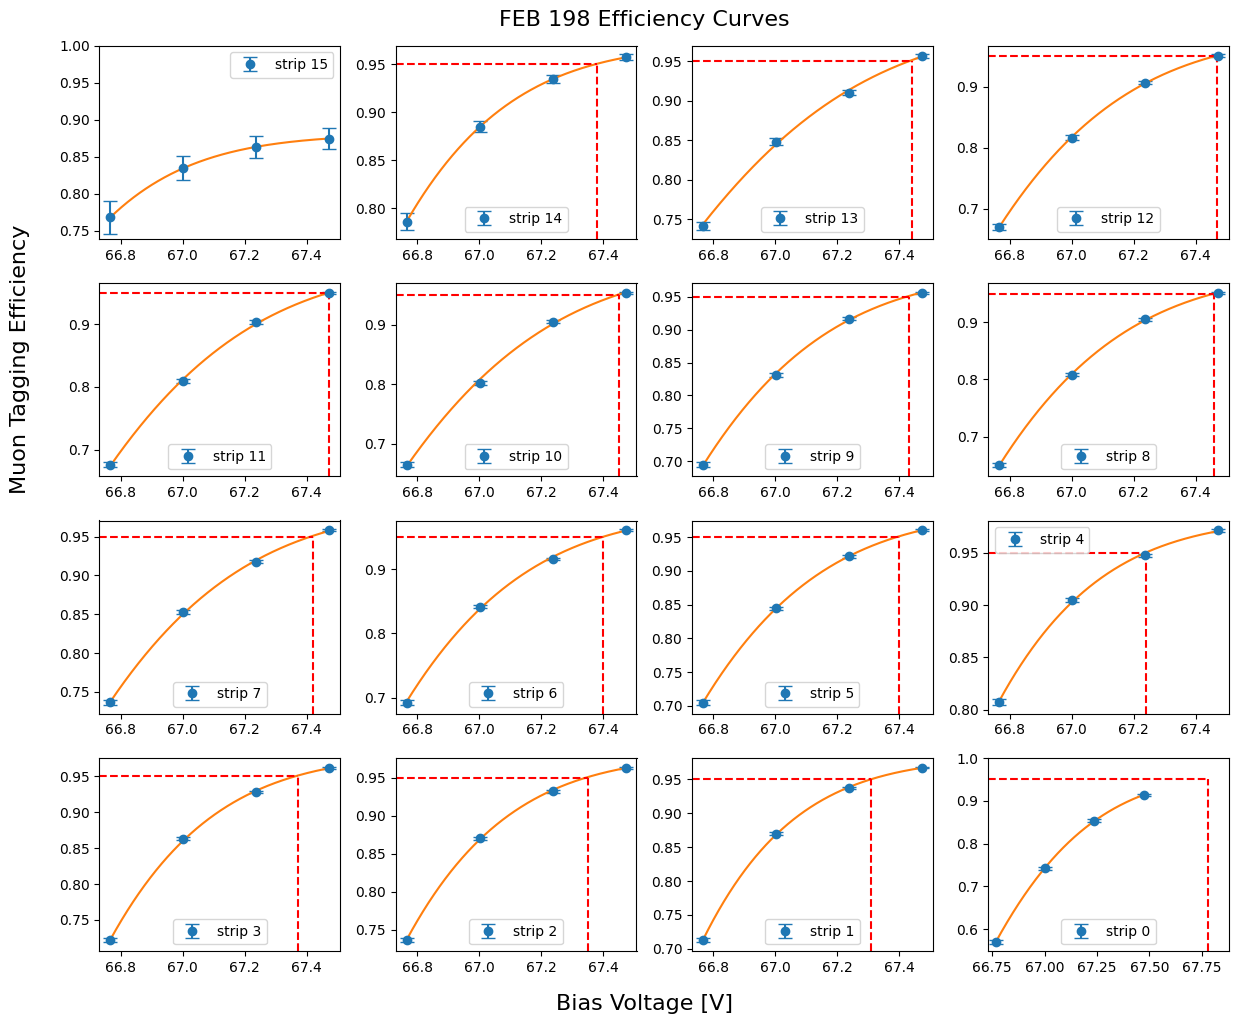

<Figure size 640x480 with 0 Axes>

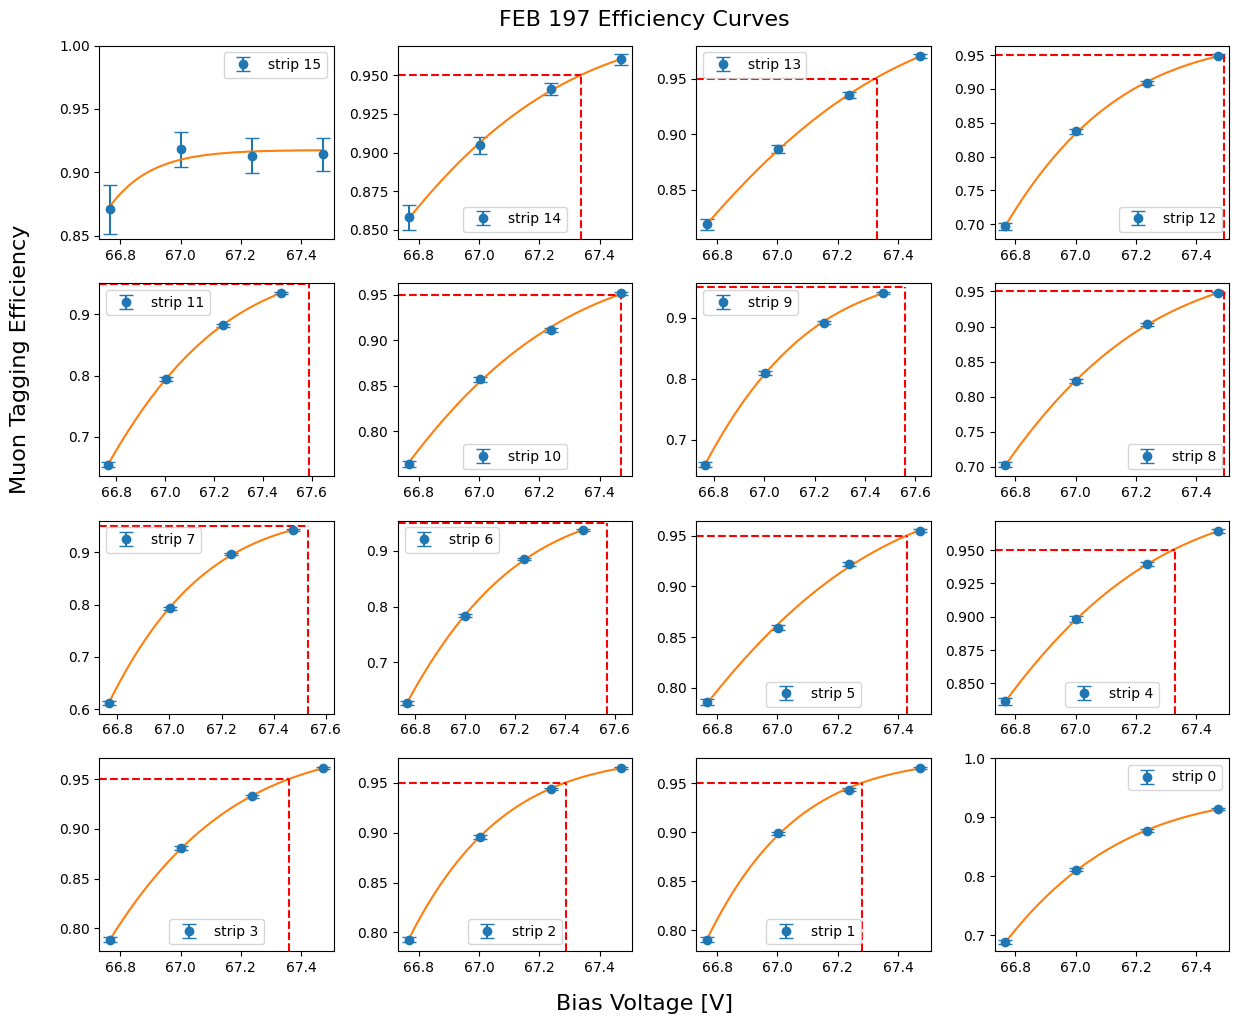

<Figure size 640x480 with 0 Axes>

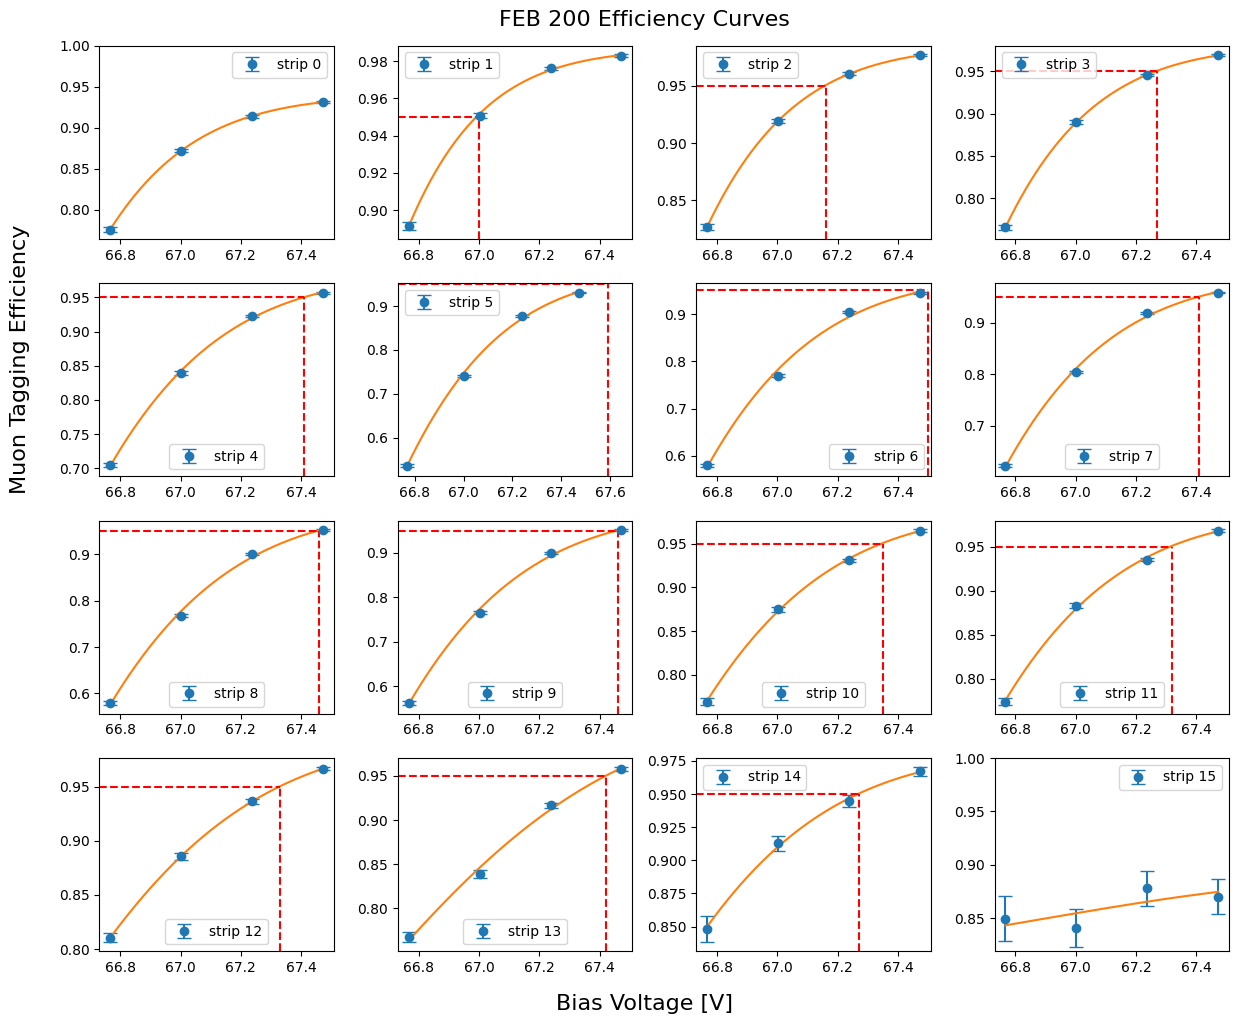

<Figure size 640x480 with 0 Axes>

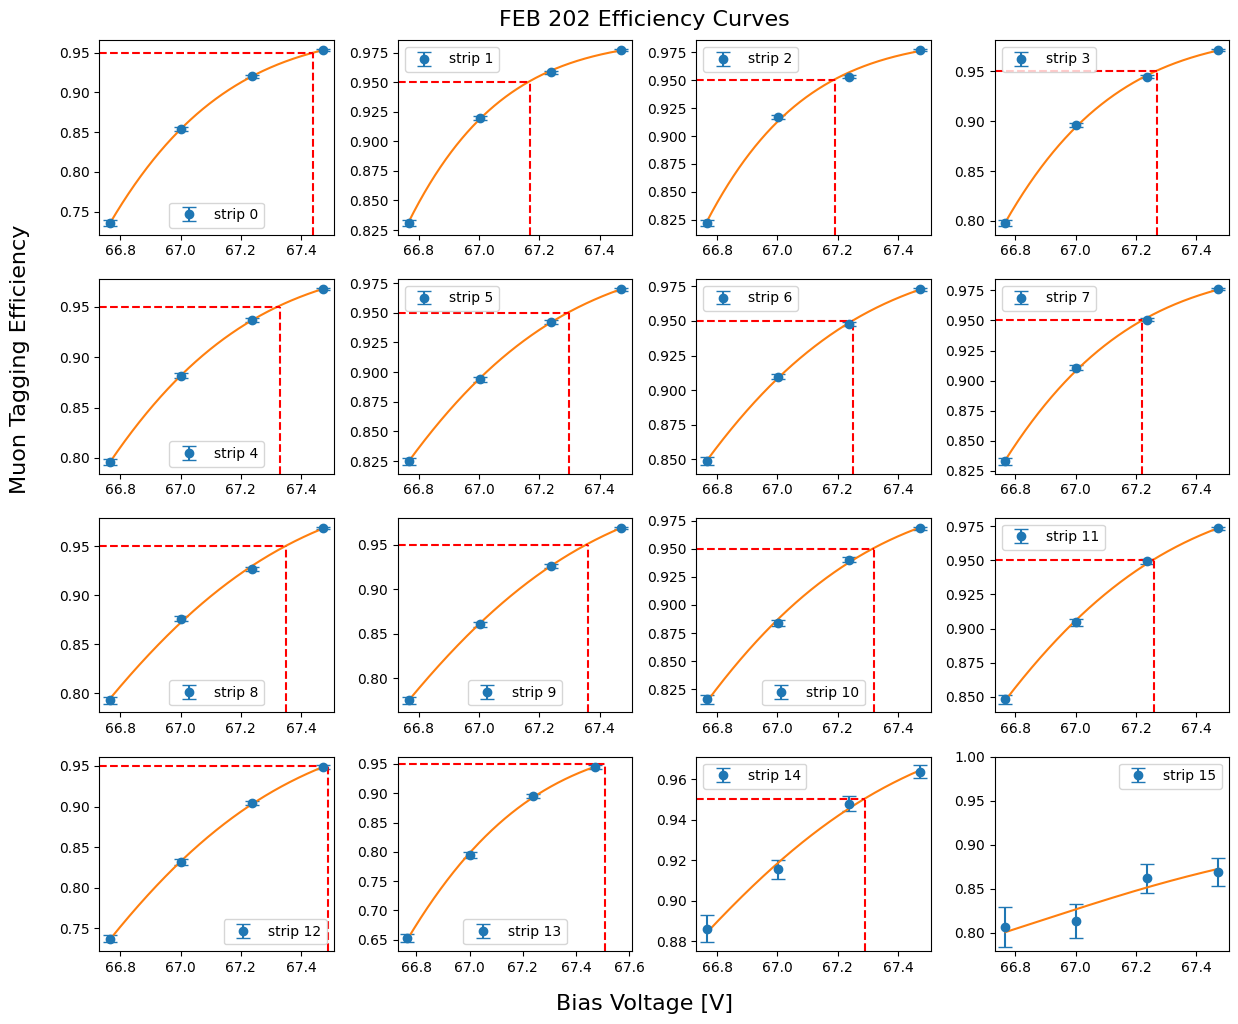

<Figure size 640x480 with 0 Axes>

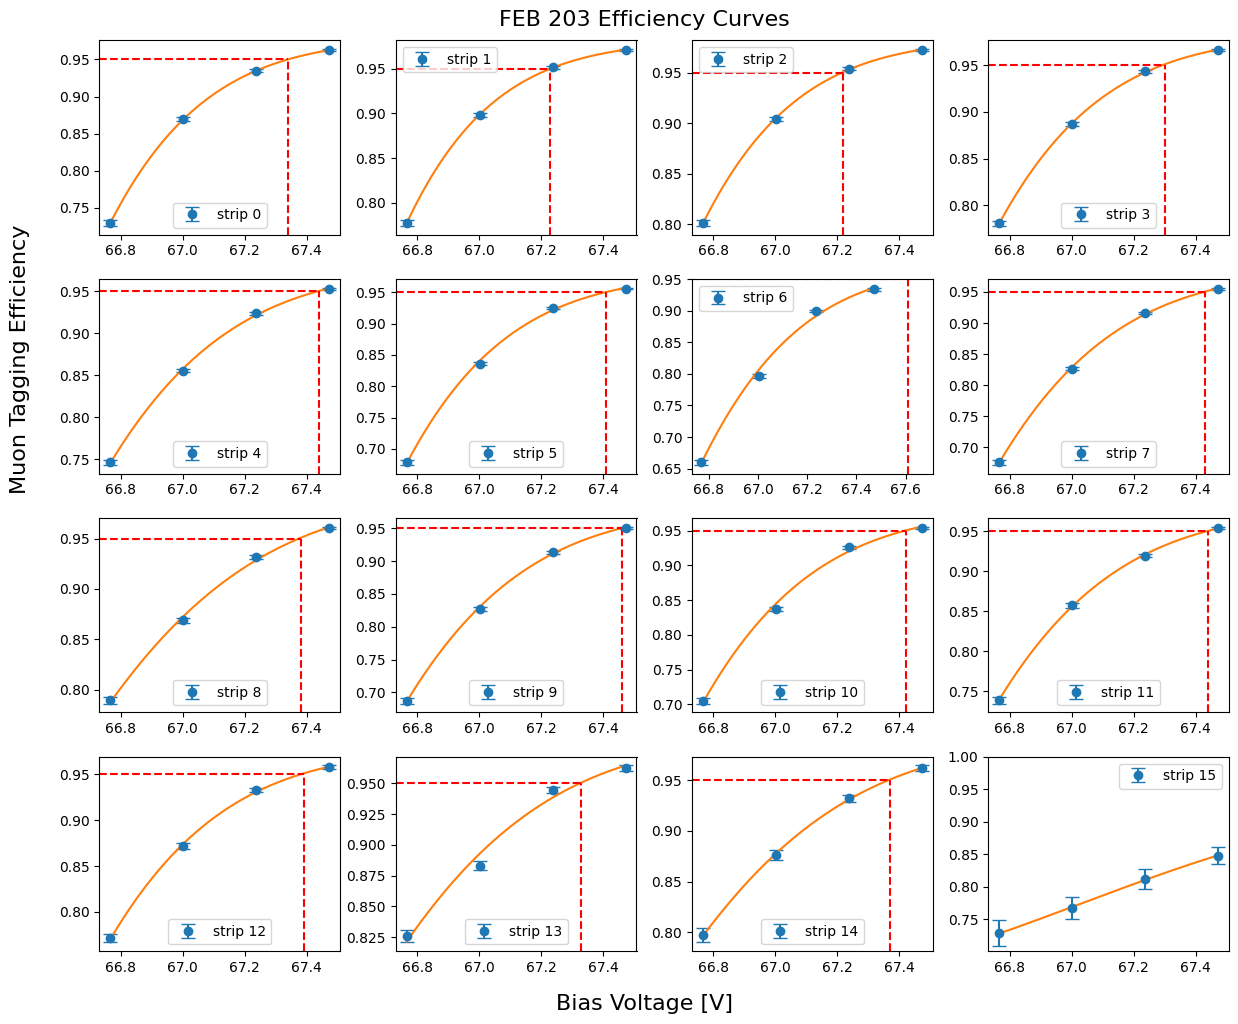

Finished extracting bias settings
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extens

<Figure size 640x480 with 0 Axes>

In [30]:
import matplotlib.cm as cm
from scipy.optimize import curve_fit
from scipy import special
import math


def eff_func(x, a, b, c):
        return a*special.erf(x-c, out=None) + b


def inv_func(a, b, c, goal):
        #return special.erfinv((y-b)/a, out=None)
        flag = 1
        x = 40.0
        while(flag):
                y = eff_func(x, a, b, c)
                if (y > goal):
                        flag = 0
                        return x
                if (x > 90.0):
                        flag = 0
                        return -1
                x += 0.01


# Extract the bias voltage settings based on some target efficiency labled as goal

goal = 0.95

bias_dict = {}
for feb in horiz_febs:
    key = str(feb)
    # first list will be the settings, second list will be the errors on the settings
    bias_dict[key] = [[0 for num in range(16)], [0 for num in range(16)]]

for f in range(len(horiz_febs)):
    # We will plot all the fits for this feb in one large plot
    fig, axs = plt.subplots(4, 4, figsize=(12, 10))
    c_dir = channel_directions[f] # channel orientation of this FEB
    if rate_directions[f] == 1:
        # We need to flip the direction !!!
        print("Flipping Direction of FEB "+str(horiz_febs[f]))
        if c_dir:
            c_dir = 0
        else:
            c_dir = 1
            
    fits = []
    settings = []
    all_e_vals = []
    all_err_up = []
    all_err_low = []
    for s in range(16):
        e_vals = []
        v_vals = []
        err_up = []
        err_low = []
        # Loop over the runs and fill the efficiency points
        for r in range(len(all_runs)):
            run_index = map.runs.index(all_runs[r])
            v_vals.append(map.real_voltages[run_index])
               
            if c_dir:
                e_vals.append(all_strip_eff_objects[r][f].GetBinContent(s+1))
                err_up.append(all_strip_eff_objects[r][f].GetBinError(s+1))
                err_low.append(all_strip_eff_objects[r][f].GetBinError(s+1))
                
            else:
                e_vals.append(all_strip_eff_objects[r][f].GetBinContent((s-16)*-1))
                err_up.append(all_strip_eff_objects[r][f].GetBinError((s-16)*-1))
                err_low.append(all_strip_eff_objects[r][f].GetBinError((s-16)*-1))

        # fit the efficiency curve for this FEB and this strip (s)
        popt, pcov = 0, 0
        try:
            popt, pcov = curve_fit(eff_func, v_vals, e_vals, p0=[1.0, 0.0, 66.0], sigma=err_up)         
        except:
            print("Failed eff curve fit !!!")
            continue
            
        # Extract the bias voltage setting for feb f, strip s       
        b = inv_func(popt[0], popt[1], popt[2], goal)
        settings.append(b)
        fits.append(popt)
        all_e_vals.append(e_vals)
        all_err_up.append(err_up)
        all_err_low.append(err_low)

    # End loop over the strips: start plotting the results for this feb
    count = 0
    x_data = np.linspace(min(v_vals), max(v_vals), 1000)
    for i in range(4):
        for j in range(4):
            e_vals = all_e_vals[count]
            err_up = all_err_up[count]
            if c_dir:
                # place the results in the dictionary
                b = settings[count]
                bias_dict[str(horiz_febs[f])][0][count] = settings[count]
                bias_dict[str(horiz_febs[f])][1][count] = 0 # TODO --> Need to estimate the error !!!
            
                axs[i, j].errorbar(v_vals, e_vals, yerr=err_up, fmt='o', capsize=5, label="strip " + str(count))
                #x_data = np.linspace(v_vals[0], v_vals[-1], 1000)
                axs[i, j].plot(x_data, eff_func(x_data, fits[count][0], fits[count][1], fits[count][2])) 
                #label="Fit: a = "+str(round(fits[count][0], 3)) + " b = "+str(round(fits[count][1], 3)) + " c = "+str(round(fits[count][2], 3)))
                #label="Fit")
                x_limits = list(axs[i, j].get_xlim())
                y_limits = list(axs[i, j].get_ylim())
                axs[i, j].plot([b,b], [y_limits[0], goal], c='r', linestyle='--')
                axs[i, j].plot([x_limits[0], b], [goal, goal], c='r', linestyle='--')
                if b > x_limits[1]:
                    x_limits[1] = b + 0.1
                if goal > y_limits[1]:
                    y_limits[1] = goal + 0.05
                axs[i, j].set_xlim(x_limits[0], x_limits[1])
                axs[i, j].set_ylim(y_limits[0], y_limits[1])
                #axs[i, j].set_xlabel("Bias Voltage [V]")
                #axs[i, j].set_ylabel("Efficiency")
                #axs[i, j].legend(title="Frame "+str(frame) + ", FEB "+str(horiz_febs[f]))
                axs[i,j].legend()
                count += 1
            else:
                b = settings[count]
                bias_dict[str(horiz_febs[f])][0][(count-15)*-1] = settings[count]
                bias_dict[str(horiz_febs[f])][1][(count-15)*-1] = 0 # TODO --> Need to estimate the error !!!
                axs[i, j].errorbar(v_vals, e_vals, yerr=err_up, fmt='o', capsize=5, label="strip " + str((count-15)*-1))
                #x_data = np.linspace(v_vals[0], v_vals[-1], 1000)
                axs[i, j].plot(x_data, eff_func(x_data, fits[count][0], fits[count][1], fits[count][2])) 
                #label="Fit: a = "+str(round(fits[count][0], 3)) + " b = "+str(round(fits[count][1], 3)) + " c = "+str(round(fits[count][2], 3)))
                #label="Fit")
                x_limits = list(axs[i, j].get_xlim())
                y_limits = list(axs[i, j].get_ylim())
                axs[i, j].plot([b,b], [y_limits[0], goal], c='r', linestyle='--')
                axs[i, j].plot([x_limits[0], b], [goal, goal], c='r', linestyle='--')
                if b > x_limits[1]:
                    x_limits[1] = b + 0.1
                if goal > y_limits[1]:
                    y_limits[1] = goal + 0.05
                axs[i, j].set_xlim(x_limits[0], x_limits[1])
                axs[i, j].set_ylim(y_limits[0], y_limits[1])
                #axs[i, j].set_xlabel("Bias Voltage [V]")
                #axs[i, j].set_ylabel("Efficiency")
                #axs[i, j].legend(title="Frame "+str(frame) + ", FEB "+str(horiz_febs[f]))
                axs[i,j].legend()
                count += 1
              
    fig.suptitle("FEB " + str(horiz_febs[f]) + " Efficiency Curves", fontsize=16)
    #fig.set_title("Run " + str(run))
    # Adjust layout to prevent overlap
    fig.text(0.5, -0.02, 'Bias Voltage [V]', ha='center', fontsize=16)
    fig.text(-0.02, 0.5, 'Muon Tagging Efficiency', ha='center', rotation='vertical', fontsize=16)
    plt.tight_layout()
    # Show the plot
    plt.show()
    plt.savefig(fig_dir+"frame"+str(frame)+"_eff_curves_feb"+str(horiz_febs[f])+"_"+str(int(100*goal))+".png", 
                format='png')

print("Finished extracting bias settings")

In [28]:
# Save the results to a ROOT file
bias_settings_tree = ROOT.TNtuple("bias_settings_frame"+str(frame), "", "frame:feb:strip:v:goal")
for key in bias_dict.keys():
    for num in range(len(bias_dict[key][0])):
        bias_settings_tree.Fill(frame, int(key), num, bias_dict[key][0][num], goal)
        
bias_settings_tree.SetDirectory(0)

bias_file = ROOT.TFile("../BiasFiles/"+outfile, "RECREATE")
bias_file.cd()
bias_settings_tree.Write()
bias_file.Close()

print("Saved Results to a ROOT TNtuple")

Saved Results to a ROOT TNtuple


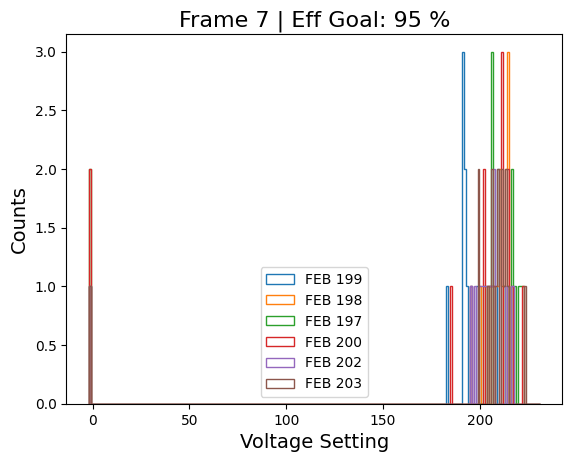

<Figure size 640x480 with 0 Axes>

In [29]:
# plot the resulting settings
def calc_setting(v):
    return 255 - ((255.0/4)*(68.1 - v))

b = np.linspace(-2, 231, 233)

bias_voltage_arrays = []
febs = []
for key in bias_dict.keys():
    febs.append(int(key))
    new_arr = []
    for num in range(len(bias_dict[key][0])):
        s = bias_dict[key][0][num]
        if s > 0:
            s = calc_setting(s)
        new_arr.append(s)
    bias_voltage_arrays.append(new_arr)

for num in range(len(bias_voltage_arrays)):
    plt.hist(np.array(bias_voltage_arrays[num]), bins=b, histtype='step', label="FEB "+str(febs[num]))


plt.legend()
plt.title("Frame 7 | Eff Goal: "+str(int(100*goal))+ " %", fontsize=16)
plt.xlabel("Voltage Setting", fontsize=14)
plt.ylabel("Counts", fontsize=14)
#plt.xlim(190, 240)
plt.show()
plt.savefig(fig_dir+"frame"+str(frame)+"_voltage_settings_"+str(int(100*goal))+".png", format='png')